ARIMA models are capable of capturing a suite of different standard temporal structures in time-series data.


# Importing the modules

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import yfinance as yf
import time

# Getting the Data from Yahoo and Store into Pandas df

In [17]:
# Getting the data
time.sleep(1)
nvda = yf.Ticker("NVDA")
time.sleep(1)
# Get the 1 year historical data for NVDA
nvda_hist = nvda.history(period="5y")

# Make a pandas dataframe
nvda_df = pd.DataFrame(nvda_hist)

# Drop all column except date and closeing price
nvda_df = nvda_df.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)
nvda_df.head()

,Close
Date,
2017-10-23 00:00:00-04:00,48.637718
2017-10-24 00:00:00-04:00,49.147293
2017-10-25 00:00:00-04:00,47.905495
2017-10-26 00:00:00-04:00,48.407665
2017-10-27 00:00:00-04:00,49.933929


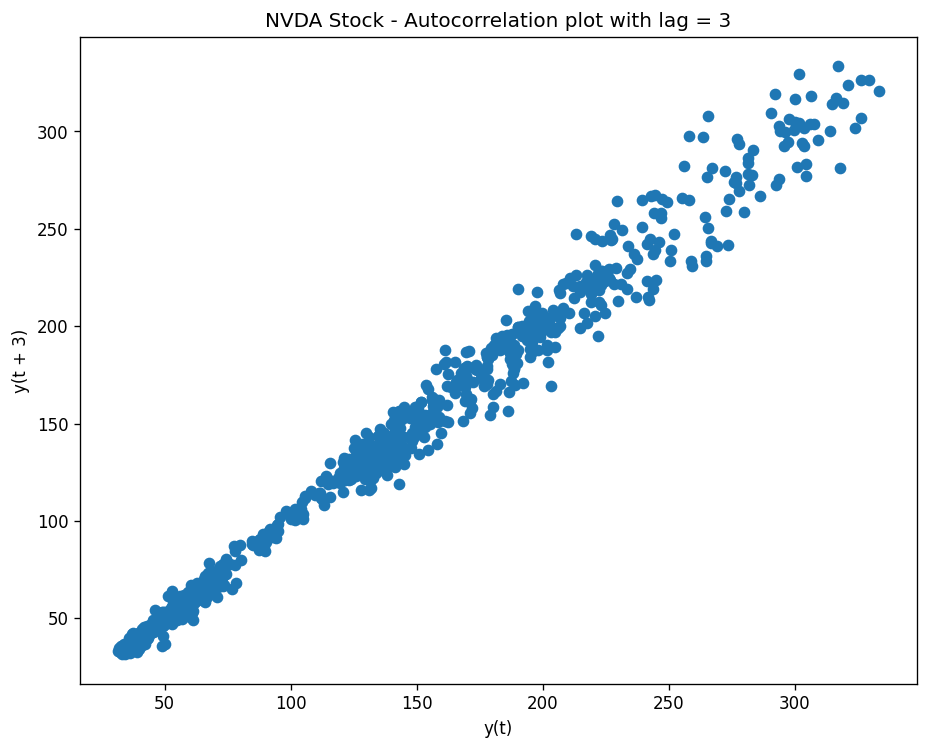

In [18]:
# Observe the cross correlation between the closing price and the lagged closing price
plt.figure()
lag_plot(nvda_df['Close'], lag=3)
plt.title('NVDA Stock - Autocorrelation plot with lag = 3')
plt.show()

This shows that ARIMA is going to be a good model to be applied to this type of data (there is auto-correlation in the data)

# Plotting of stock closing price evolution over time 

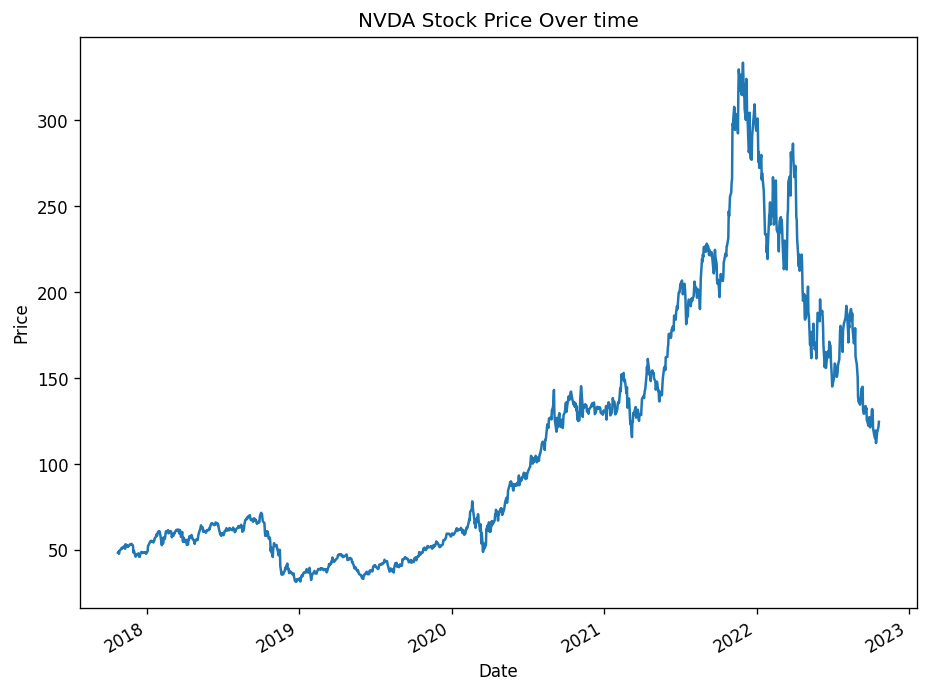

In [19]:
plt.plot(nvda_df["Close"])
plt.gcf().autofmt_xdate()
plt.title("NVDA Stock Price Over time") 
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()  


# Finding the d Parameters for ARIMA
- The d parameter is the number of nonseasonal differences required for stationarity
- The d parameter is the number of times that the raw observations are differenced, in order to get a stationary series

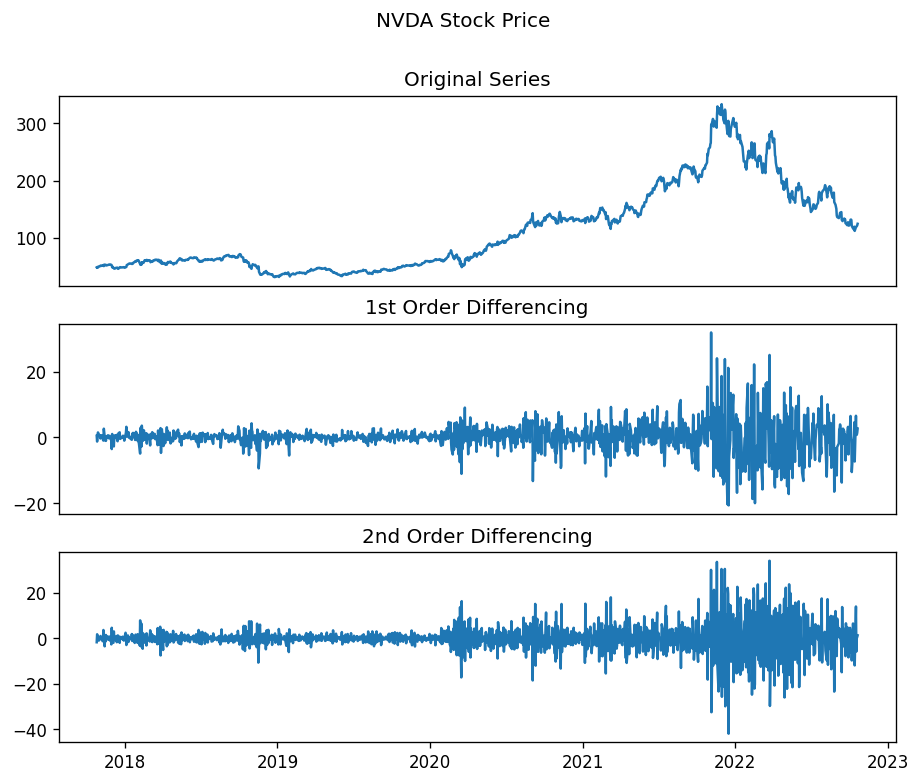

In [20]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('NVDA Stock Price')
ax1.plot(nvda_df['Close'])
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)

# 1st Differencing
ax2.plot(nvda_df['Close'].diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

# 2nd Differencing
ax3.plot(nvda_df['Close'].diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()


- In first-order differencing we have fewer noises in the data while after 1st order there is an increase in the noise. 
- So we can select 1st order differencing for our model. 
- We can also verify this using an autocorrelation plot. 

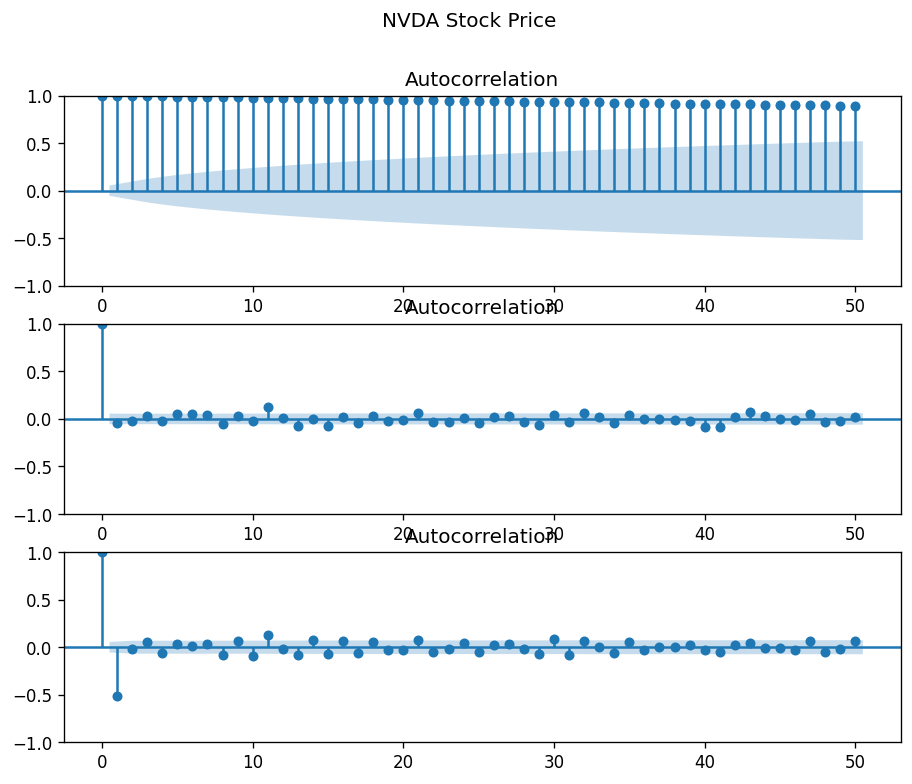

In [21]:
# Autocoorelation plot
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('NVDA Stock Price')
plot_acf(nvda_df['Close'], ax=ax1, lags=50)
plot_acf(nvda_df['Close'].diff().dropna(), ax=ax2, lags=50)
plot_acf(nvda_df['Close'].diff().diff().dropna(), ax=ax3, lags=50)
# plot_acf(nvda_df['Close'].diff(), ax=ax1)
# plot_acf(nvda_df['Close'].diff().diff().dropna(), ax=ax2)
# plot_acf(nvda_df['Close'].diff().diff().dropna(), ax=ax3)
plt.show()


- In second-order differencing the immediate lag has gone on the negative side, representing that in the second-order the series has become over the difference. 

# Finding the p paramter for ARIMA
- p is the number of autoregressive terms
- Use the PACF plot to find this value

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


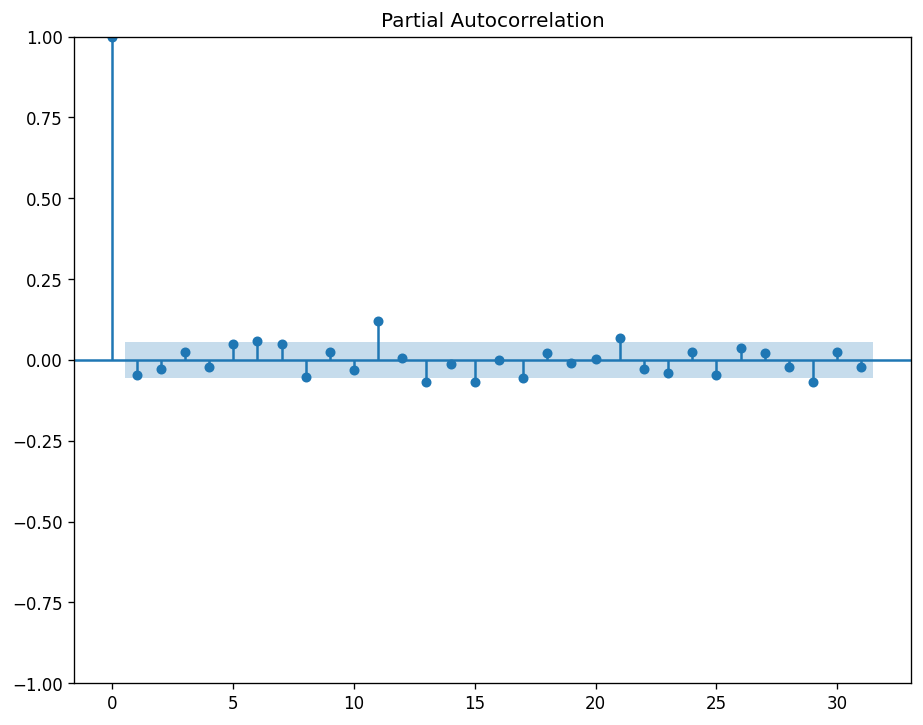

In [22]:
# Finding the p paramter for ARIMA
plot_pacf(nvda_df['Close'].diff().dropna())
plt.show()

- Here we can see that the first lag is significantly out of the limit
- Even for other lag that is out of the limit, it is not that far off, thus p is 1

# Finding the value of the q paramter
- q is the size/width of the moving average window
- Use the ACF plot to show how much moving average is required to remove the autocorrelation from the stationary time series

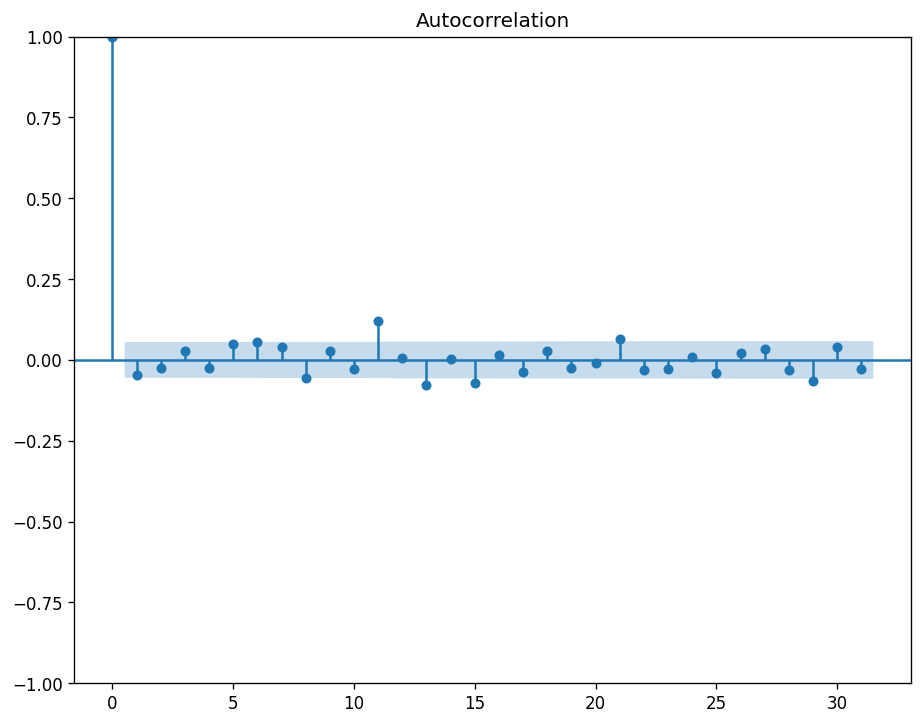

In [23]:
# Finding the q paramter for ARIMA
plot_acf(nvda_df['Close'].diff().dropna())
plt.show()

- There is 2 lags out of significance limit, however only the first one is significantly out of the limit, thus the q value is 1

# Build the predictive ARIMA model

- Split the training dataset into train and test sets and we use the train set to fit the model, and generate a prediction for each element on the test set.
- A rolling forecasting procedure is required given the dependence on observations in prior time steps for differencing and the AR model. To this end, re-create the ARIMA model after each new observation is received.
- Finally, manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended at each iteration.
- From above, the order of the ARIMA is (1,1,1)

In [24]:
train_data, test_data = nvda_df[0:int(len(nvda_df)*0.7)], nvda_df[int(len(nvda_df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = sm.tsa.arima.ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
RMSE_error = np.sqrt(MSE_error)
print('Testing Mean Squared Error is {}'.format(MSE_error))
print('Testing Root Mean Squared Error is {}'.format(RMSE_error))

Testing Mean Squared Error is 57.48713904237481
Testing Root Mean Squared Error is 7.582027370194255


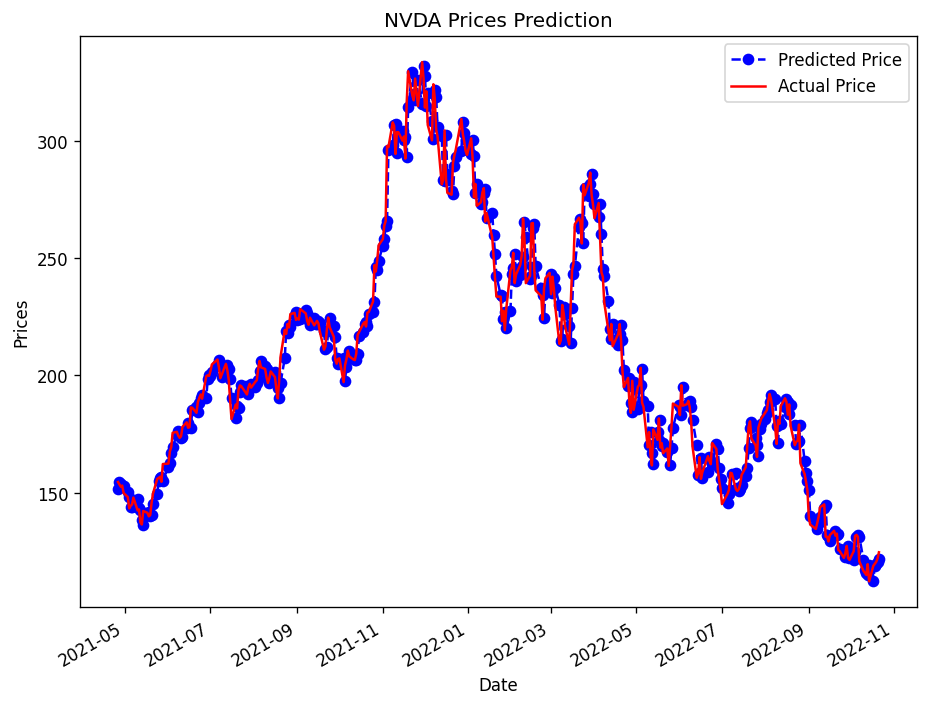

In [25]:
test_set_range = nvda_df[int(len(nvda_df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('NVDA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

# Now train with the whole data so that we can predict future closing prices

In [26]:
actualModel = sm.tsa.arima.ARIMA(nvda_df['Close'], order=(1, 1, 1))
actualModel_fit = actualModel.fit()
print(actualModel_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3696.800
Date:                Sat, 22 Oct 2022   AIC                           7399.600
Time:                        12:38:52   BIC                           7415.012
Sample:                             0   HQIC                          7405.392
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2140      0.258      0.830      0.406      -0.291       0.719
ma.L1         -0.2646      0.254     -1.041      0.298      -0.763       0.234
sigma2        20.8924      0.392     53.239      0.0

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
# Forecast for the next 15 days
forecast = actualModel_fit.forecast(steps=15)

# Make a empty dataframe
forecast_df = pd.DataFrame(columns=['Date'])
forecast_df['Date'] = pd.date_range(start='2022-10-23', end='2022-11-04')

# Add the forecasted values to the dataframe
forecast_df['Forecast'] = forecast.iloc[0]

for i in range(0, len(forecast_df)-1):
    forecast_df.iloc[i,1] = forecast.iloc[i]

# Make date as index
forecast_df = forecast_df.set_index('Date')
forecast_df
forecast_df.to_csv('YangJiAN_Impl_2.csv')



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
forecast_df

,Forecast
Date,
2022-10-23,124.498255
2022-10-24,124.463639
2022-10-25,124.456230
2022-10-26,124.454645
2022-10-27,124.454306
2022-10-28,124.454233
2022-10-29,124.454217
2022-10-30,124.454214
2022-10-31,124.454213


# Plot the predicted value and the actual value

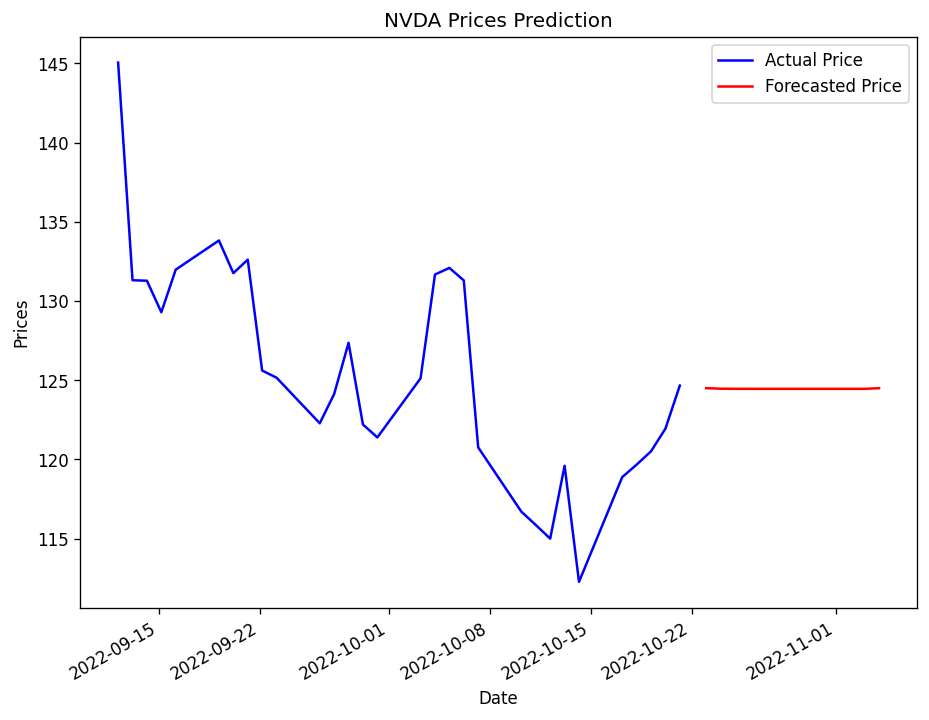

In [29]:
# Get the last 30 days of the original data
last_30_days = nvda_df[-30:]

# Plot the recent forecasted values with the actual values
plt.plot(last_30_days['Close'], color='blue', label='Actual Price')
plt.plot(forecast_df['Forecast'], color = "red", label='Forecasted Price')
plt.title('NVDA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()